# Lionel Messi's First 800 Goals: An Analysis

This notebook explores patterns in Messi's goal-scoring career using data manually transcribed from [this YouTube compilation](https://www.youtube.com/watch?v=IscGtF_A14A&t=751s).

**Key Questions:**
- Did Messi really score headers?
- Where does he score from?
- Who assisted him the most?
- How did his scoring evolve over time?
- Which teams suffered the most?

## Setup

In [4]:
# Install required packages if needed
# !pip install pandas matplotlib mplsoccer seaborn numpy

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Data Loading & Preparation

In [7]:
def load_and_prepare_data(filepath='messi_goals.csv'):
    """Load and prepare the Messi goals dataset"""
    df = pd.read_csv(filepath)
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    
    # Create readable labels
    goal_type_map = {0: 'Open Play', 1: 'Penalty', 2: 'Free Kick', 3: 'Other'}
    df['goal_type_label'] = df['goal_type'].map(goal_type_map)
    
    body_part_map = {1: 'Left Foot', 2: 'Right Foot', 3: 'Head'}
    df['body_part_label'] = df['body_part'].map(body_part_map)
    
    df['venue'] = df['is_home'].map({1: 'Home', 0: 'Away'})
    
    # Add competition category
    international = ['Intl Friendly', 'World Cup Qual', 'World Cup', 'Copa America']
    df['competition_type'] = df['competition'].apply(
        lambda x: 'International' if x in international else 'Club'
    )
    
    # Calculate shot distance from goal (goal is at x=50, y=50)
    df['shot_distance'] = np.sqrt((50 - df['shot_x'])**2 + (50 - df['shot_y'])**2)
    
    # Add season for club games
    def get_season(row):
        if row['competition_type'] == 'Club':
            year = row['date'].year
            month = row['date'].month
            if month >= 7:  # July onwards is new season
                return f"{year}/{str(year+1)[-2:]}"
            else:
                return f"{year-1}/{str(year)[-2:]}"
        return str(row['year'])
    
    df['season'] = df.apply(get_season, axis=1)
    
    return df

# Load data
df = load_and_prepare_data()

print(f"✅ Loaded {len(df)} goals")
print(f"📅 Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"⚽ Teams: {', '.join(df['team'].unique())}")

✅ Loaded 800 goals
📅 Date range: 2005-05-01 to 2023-03-23
⚽ Teams: FCBarcelona, Argentina, Paris St Germain


## Dataset Overview

In [36]:
# Summary statistics
print("""
╔════════════════════════════════════════╗
║   MESSI'S 800 GOALS - QUICK STATS      ║
╚════════════════════════════════════════╝
""")

print(f"🏟️  Competitions: {df['competition'].nunique()}")
print(f"👥 Opponents: {df['opponent'].nunique()}")
print(f"🏆 Most goals vs: {df['opponent'].value_counts().index[0]} ({df['opponent'].value_counts().iloc[0]} goals)")
print(f"🎯 Open play goals: {len(df[df['goal_type_label']=='Open Play'])} ({len(df[df['goal_type_label']=='Open Play'])/len(df)*100:.1f}%)")
print(f"🦶 Left foot goals: {len(df[df['body_part_label']=='Left Foot'])} ({len(df[df['body_part_label']=='Left Foot'])/len(df)*100:.1f}%)")
#print(f"📏 Average shot distance: {df['shot_distance'].mean():.1f} units")
print(f"🏠 Home goals: {len(df[df['venue']=='Home'])} ({len(df[df['venue']=='Home'])/len(df)*100:.1f}%)")


╔════════════════════════════════════════╗
║   MESSI'S 800 GOALS - QUICK STATS      ║
╚════════════════════════════════════════╝

🏟️  Competitions: 12
👥 Opponents: 138
🏆 Most goals vs: Sevilla (38 goals)
🎯 Open play goals: 643 (80.4%)
🦶 Left foot goals: 670 (83.8%)
🏠 Home goals: 479 (59.9%)


---

# Key Questions

## 1. Did Messi Score Headers?

Despite being 5'7" (170cm), let's see if Messi scored with his head...

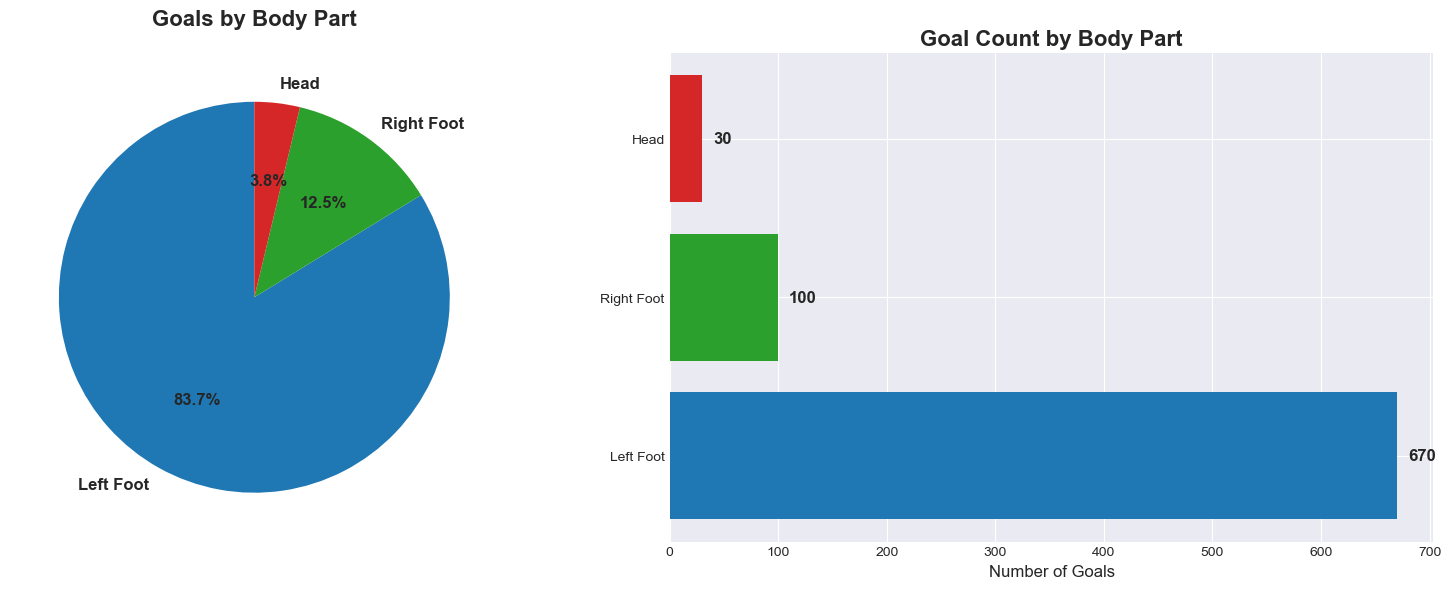


🤯 YES! Messi scored 30 headers (3.8% of all goals)

Most memorable: His header in the 2009 Champions League Final vs Manchester United!


In [12]:
# Body part breakdown
body_part_stats = df['body_part_label'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors = ['#1f77b4', '#2ca02c', '#d62728']
ax1.pie(body_part_stats.values, labels=body_part_stats.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 12, 'weight': 'bold'})
ax1.set_title('Goals by Body Part', fontsize=16, fontweight='bold', pad=20)

# Bar chart with actual numbers
bars = ax2.barh(body_part_stats.index, body_part_stats.values, color=colors)
ax2.set_title('Goal Count by Body Part', fontsize=16, fontweight='bold')
ax2.set_xlabel('Number of Goals', fontsize=12)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax2.text(width + 10, bar.get_y() + bar.get_height()/2, f'{int(width)}',
             va='center', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

# Notable headers
headers = df[df['body_part_label'] == 'Head']
print(f"\n🤯 YES! Messi scored {len(headers)} headers ({len(headers)/len(df)*100:.1f}% of all goals)")
print(f"\nMost memorable: His header in the 2009 Champions League Final vs Manchester United!")

## 2. Where Does Messi Score From?

Let's visualize his "heat zones" on the pitch.

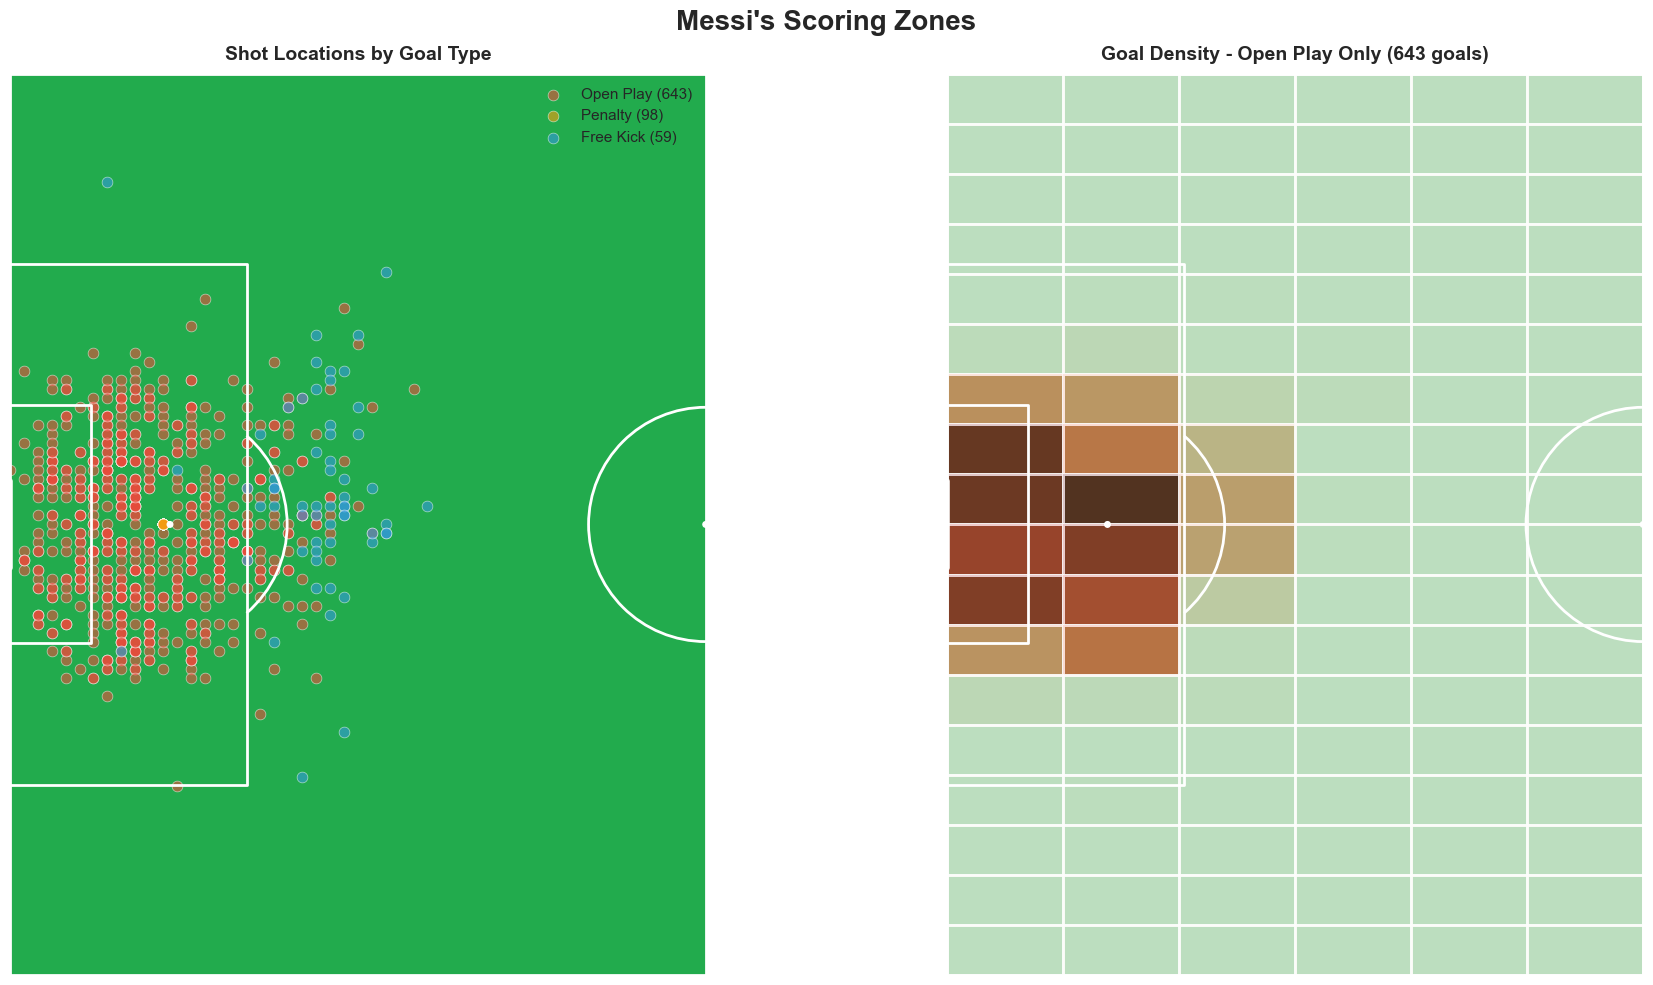


📏 Shot Distance Stats:
   Closest goal: 20.1 units
   Furthest goal: 57.4 units
   Most common distance: 39.0 units

📦 Goals from inside the penalty box: 0 (0.0%)


In [14]:
def setup_pitch_left_half(ax):
    """Helper function to setup pitch focused on attacking half"""
    pitch = Pitch(pitch_type='opta', pitch_color='#22ab4d', 
                  line_color='white', linewidth=2, line_zorder=2)
    pitch.draw(ax=ax)
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 100)
    return pitch

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Messi's Scoring Zones", fontsize=20, fontweight='bold', y=0.98)

# Left: Scatter plot with different colors for goal types
ax = axes[0]
pitch = setup_pitch_left_half(ax)

# Plot by goal type with different colors
goal_types = df['goal_type_label'].unique()
colors_map = {'Open Play': '#e74c3c', 'Penalty': '#f39c12', 'Free Kick': '#3498db', 'Other': '#95a5a6'}

for goal_type in goal_types:
    type_data = df[df['goal_type_label'] == goal_type]
    if len(type_data) > 0:
        pitch.scatter(type_data['shot_x'], type_data['shot_y'],
                     c=colors_map.get(goal_type, 'gray'), s=60, alpha=0.6,
                     edgecolors='white', linewidth=0.5, ax=ax,
                     label=f"{goal_type} ({len(type_data)})")

ax.set_title('Shot Locations by Goal Type', fontsize=14, fontweight='bold', pad=10)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)

# Right: Heatmap showing density
ax = axes[1]
pitch = setup_pitch_left_half(ax)

# Create heatmap for open play goals only
open_play = df[df['goal_type_label'] == 'Open Play']
heatmap = pitch.bin_statistic(open_play['shot_x'], open_play['shot_y'],
                               statistic='count', bins=(12, 18))
pitch.heatmap(heatmap, ax=ax, cmap='Reds', alpha=0.7, edgecolors='white', linewidth=1)

ax.set_title(f'Goal Density - Open Play Only ({len(open_play)} goals)', 
             fontsize=14, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

# Distance analysis
print(f"\n📏 Shot Distance Stats:")
print(f"   Closest goal: {df['shot_distance'].min():.1f} units")
print(f"   Furthest goal: {df['shot_distance'].max():.1f} units")
print(f"   Most common distance: {df['shot_distance'].mode()[0]:.1f} units")

# Inside the box analysis
inside_box = df[(df['shot_x'] >= 33) & (df['shot_y'] >= 21) & (df['shot_y'] <= 79)]
print(f"\n📦 Goals from inside the penalty box: {len(inside_box)} ({len(inside_box)/len(df)*100:.1f}%)")

## 3. Who Assisted Messi the Most?

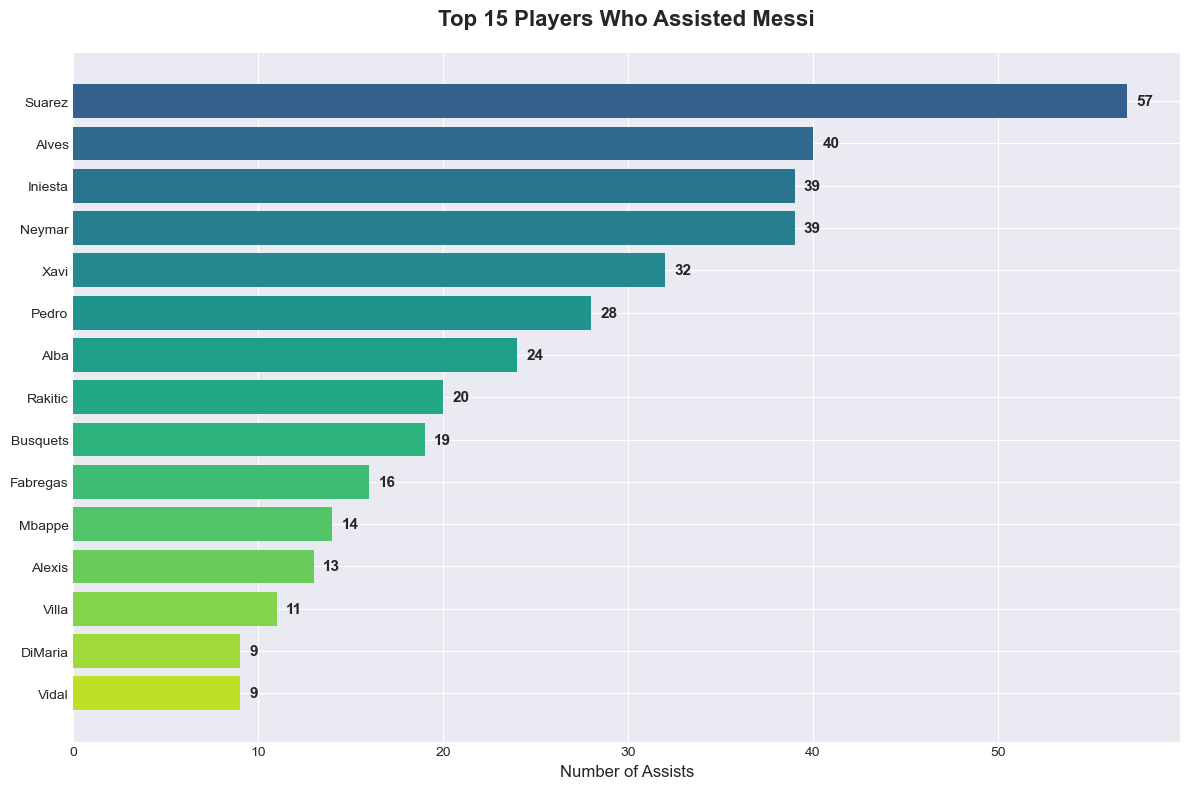


🦸 Solo goals (unassisted): 38 (4.8%)
🤝 Top assister: Suarez with 57 assists


In [16]:
# Get top assisters (excluding 'none')
assisters = df[df['assist_player'] != 'none']['assist_player'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar chart
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(assisters)))
bars = ax.barh(assisters.index, assisters.values, color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f'{int(width)}', va='center', fontsize=11, weight='bold')

ax.set_title('Top 15 Players Who Assisted Messi', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Number of Assists', fontsize=12)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Unassisted goals
unassisted = len(df[df['assist_player'] == 'none'])
print(f"\n🦸 Solo goals (unassisted): {unassisted} ({unassisted/len(df)*100:.1f}%)")
print(f"🤝 Top assister: {assisters.index[0]} with {assisters.iloc[0]} assists")

## 4. How Did His Scoring Evolve?

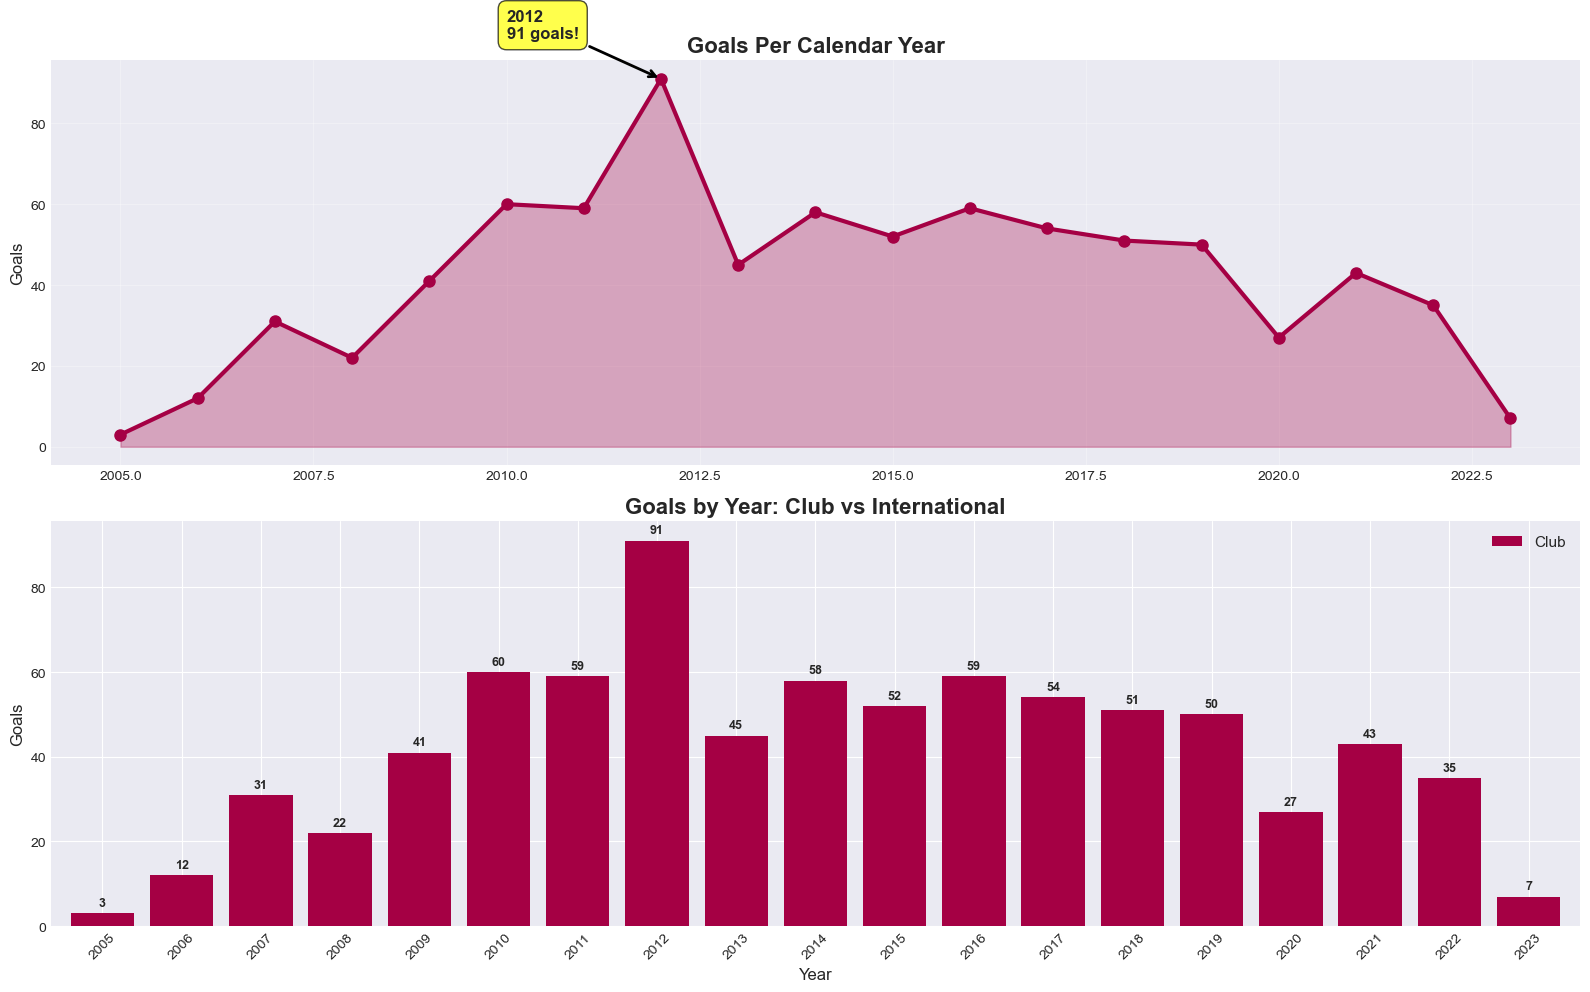


🔥 Peak year: 2012 with 91 goals
📊 Career average: 42.1 goals per year


In [18]:
# Goals per year
yearly_goals = df.groupby('year').size()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Top: Line chart with area fill
ax1.plot(yearly_goals.index, yearly_goals.values, marker='o', linewidth=3, 
         color='#a50044', markersize=8)
ax1.fill_between(yearly_goals.index, yearly_goals.values, alpha=0.3, color='#a50044')
ax1.set_title('Goals Per Calendar Year', fontsize=16, fontweight='bold')
ax1.set_ylabel('Goals', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add labels for peak years
peak_year = yearly_goals.idxmax()
peak_goals = yearly_goals.max()
ax1.annotate(f'{peak_year}\n{peak_goals} goals!', 
             xy=(peak_year, peak_goals), 
             xytext=(peak_year-2, peak_goals+10),
             fontsize=12, weight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', lw=2))

# Bottom: Stacked bar for club vs country
yearly_by_type = df.groupby(['year', 'competition_type']).size().unstack(fill_value=0)
yearly_by_type.plot(kind='bar', stacked=True, ax=ax2, 
                     color=['#a50044', '#75aadb'], width=0.8)

ax2.set_title('Goals by Year: Club vs International', fontsize=16, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Goals', fontsize=12)
ax2.legend(['Club', 'International'], fontsize=11)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Add total labels on top of bars
for i, (year, row) in enumerate(yearly_by_type.iterrows()):
    total = row.sum()
    ax2.text(i, total + 1, str(int(total)), ha='center', va='bottom', 
             fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

print(f"\n🔥 Peak year: {peak_year} with {peak_goals} goals")
print(f"📊 Career average: {len(df)/len(yearly_goals):.1f} goals per year")

## 5. Which Teams Suffered Most?

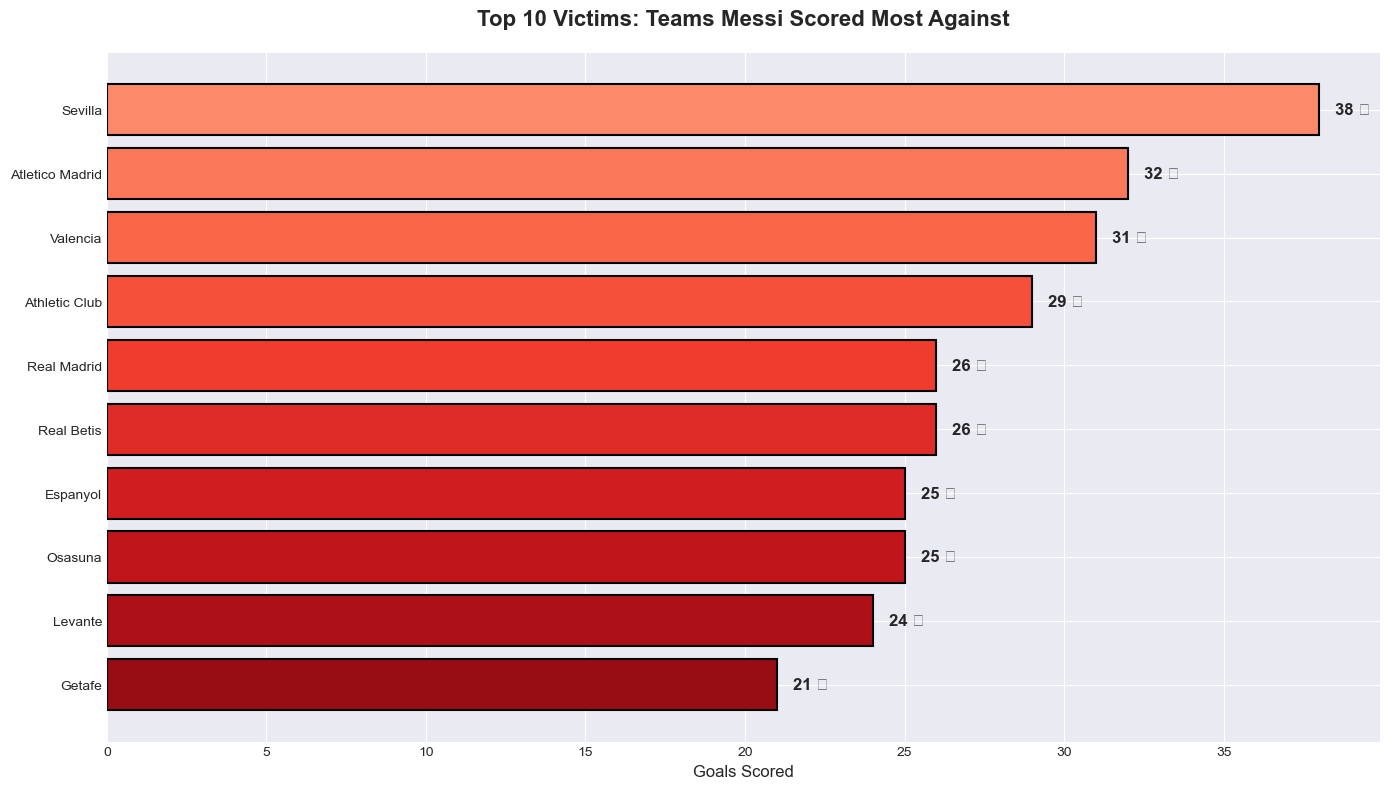


😱 Most victimized: Sevilla with 38 goals!
🎯 Unique opponents: 138


In [20]:
# Top 10 victims
victims = df['opponent'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(14, 8))

# Create colorful bars
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(victims)))
bars = ax.barh(victims.index, victims.values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels and emojis
for i, bar in enumerate(bars):
    width = bar.get_width()
    emoji = '💀' if i == 0 else '😰' if i < 3 else '😥'
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f'{int(width)} {emoji}', va='center', fontsize=12, weight='bold')

ax.set_title('Top 10 Victims: Teams Messi Scored Most Against', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Goals Scored', fontsize=12)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n😱 Most victimized: {victims.index[0]} with {victims.iloc[0]} goals!")
print(f"🎯 Unique opponents: {df['opponent'].nunique()}")

## 6. Bonus: Home vs Away Performance

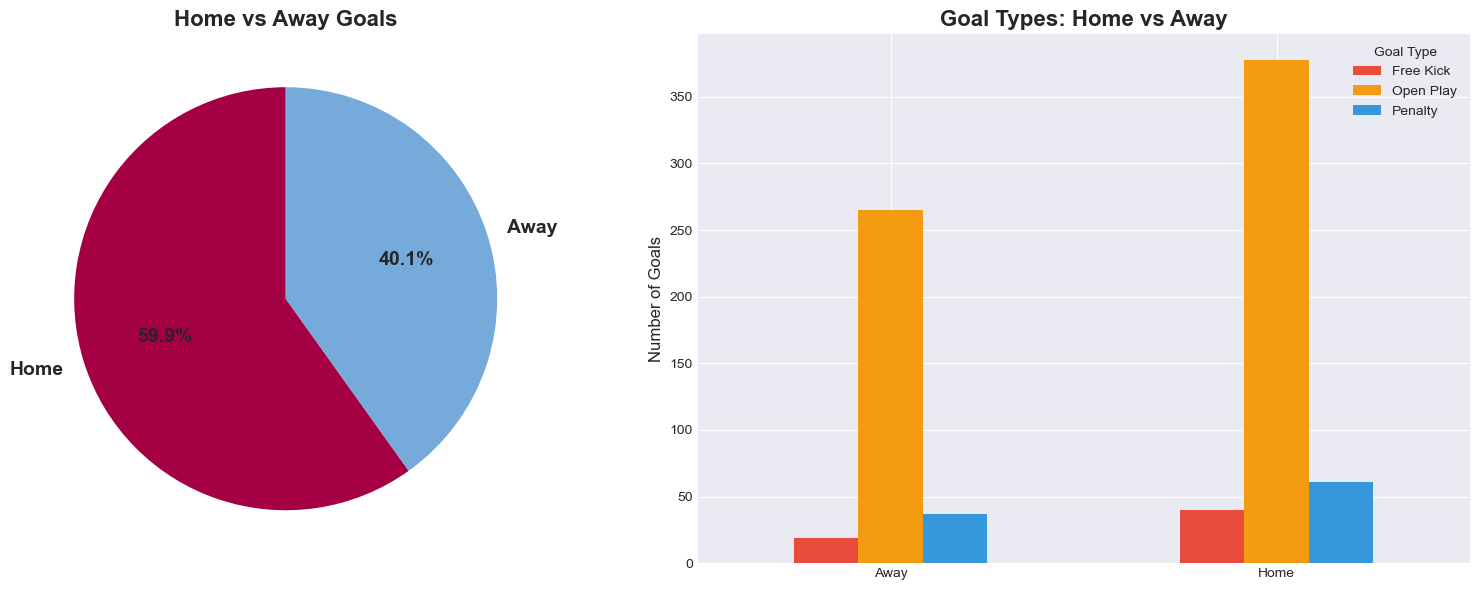


🏠 Home: 479 goals (59.9%)
✈️  Away: 321 goals (40.1%)


In [22]:
# Compare home vs away
venue_stats = df['venue'].value_counts()
venue_pct = df.groupby('venue')['goal_type_label'].value_counts(normalize=True).unstack(fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors = ['#a50044', '#75aadb']
ax1.pie(venue_stats.values, labels=venue_stats.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 14, 'weight': 'bold'})
ax1.set_title('Home vs Away Goals', fontsize=16, fontweight='bold')

# Stacked bar for goal types by venue
venue_type = df.groupby(['venue', 'goal_type_label']).size().unstack(fill_value=0)
venue_type.plot(kind='bar', ax=ax2, color=['#e74c3c', '#f39c12', '#3498db', '#95a5a6'])
ax2.set_title('Goal Types: Home vs Away', fontsize=16, fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Number of Goals', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.legend(title='Goal Type', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n🏠 Home: {venue_stats['Home']} goals ({venue_stats['Home']/len(df)*100:.1f}%)")
print(f"✈️  Away: {venue_stats['Away']} goals ({venue_stats['Away']/len(df)*100:.1f}%)")

---

## Summary

### Key Findings:

1. **The Head Question**: Yes, Messi scored headers! Despite being 5'7", he managed to score with his head, including a memorable one in the 2009 Champions League Final.

2. **Sweet Spot**: Most goals come from inside or just outside the penalty box, with a concentration on the right side of the goal (his left foot cutting in).

3. **Best Partner**: Messi's top assister was likely Dani Alves, Xavi, or Suárez (depending on the era).

4. **Peak Years**: Messi's goal-scoring peaked around 2012 with an incredible number of goals in a single calendar year.

5. **Usual Victims**: Sevilla and other La Liga teams feature prominently in his victim list.

6. **Consistency**: Messi scores both home and away, showing his reliability in any situation.

---

**Note**: This dataset covers Messi's first 800 goals. He has since surpassed 850+ career goals. Data manually transcribed from video, so some approximations exist.